In [4]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings as wr
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from pathlib import Path

wr.filterwarnings('ignore')

work_dir = Path.cwd().parent.parent / 'Work'
df = pd.read_excel(work_dir / "summary_tests.xlsx")


In [5]:
delete_columns = ['id_sample', 'age', 'sex', 'Unnamed: 0']
features = [column for column in df.columns if column not in delete_columns]

def split_data(
    df_dataset,
    cols,
    scaler,
    target_col='age',
    test_size=0.2,
    valid_size=0.2,
    random_state=42,
    get_valid_data=True
):
    X_train, X_test, y_train, y_test = train_test_split(
        df_dataset[cols],
        df_dataset[target_col],
        test_size=test_size,
        random_state=random_state
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=cols, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=cols, index=X_test.index)
    
    if not get_valid_data:
        return X_train, X_test, y_train, y_test
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size=valid_size,
        random_state=random_state
    )
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

    

scaler = StandardScaler()
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, features, scaler=scaler)  



# grid_space = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#               'C': [0.1, 1, 10],
#               'epsilon': [0.01, 0.1, 0.5]
# }

# grid = GridSearchCV(SVR(), 
#                     grid_space, 
#                     cv=5, 
#                     scoring='neg_mean_absolute_error'
# )

# grid.fit(X_train, y_train)

# print("Лучшие параметры:", grid.best_params_)
# print("Лучший результат:", grid.best_score_)

svr = SVR(kernel='linear') #обучяем модель
svr.fit(X_train, y_train)

y_train_pred = svr.predict(X_train)  # используем модель на обучающей выборке
train_mae = mean_absolute_error(y_train, y_train_pred)
print("MAE при обучающей выборке:", train_mae)

y_valid_pred = svr.predict(X_valid)  # используем модель на валидационной выборке
val_mae = mean_absolute_error(y_valid, y_valid_pred)
print("MAE при валидационной выборке:", val_mae)

y_test_pred = svr.predict(X_test)  #на тестовой
test_mae = mean_absolute_error(y_test, y_test_pred)
print("MAE при тестовой выборке:", test_mae)

MAE при обучающей выборке: 6.797398054917041
MAE при валидационной выборке: 7.766589680578565
MAE при тестовой выборке: 8.549870690960018


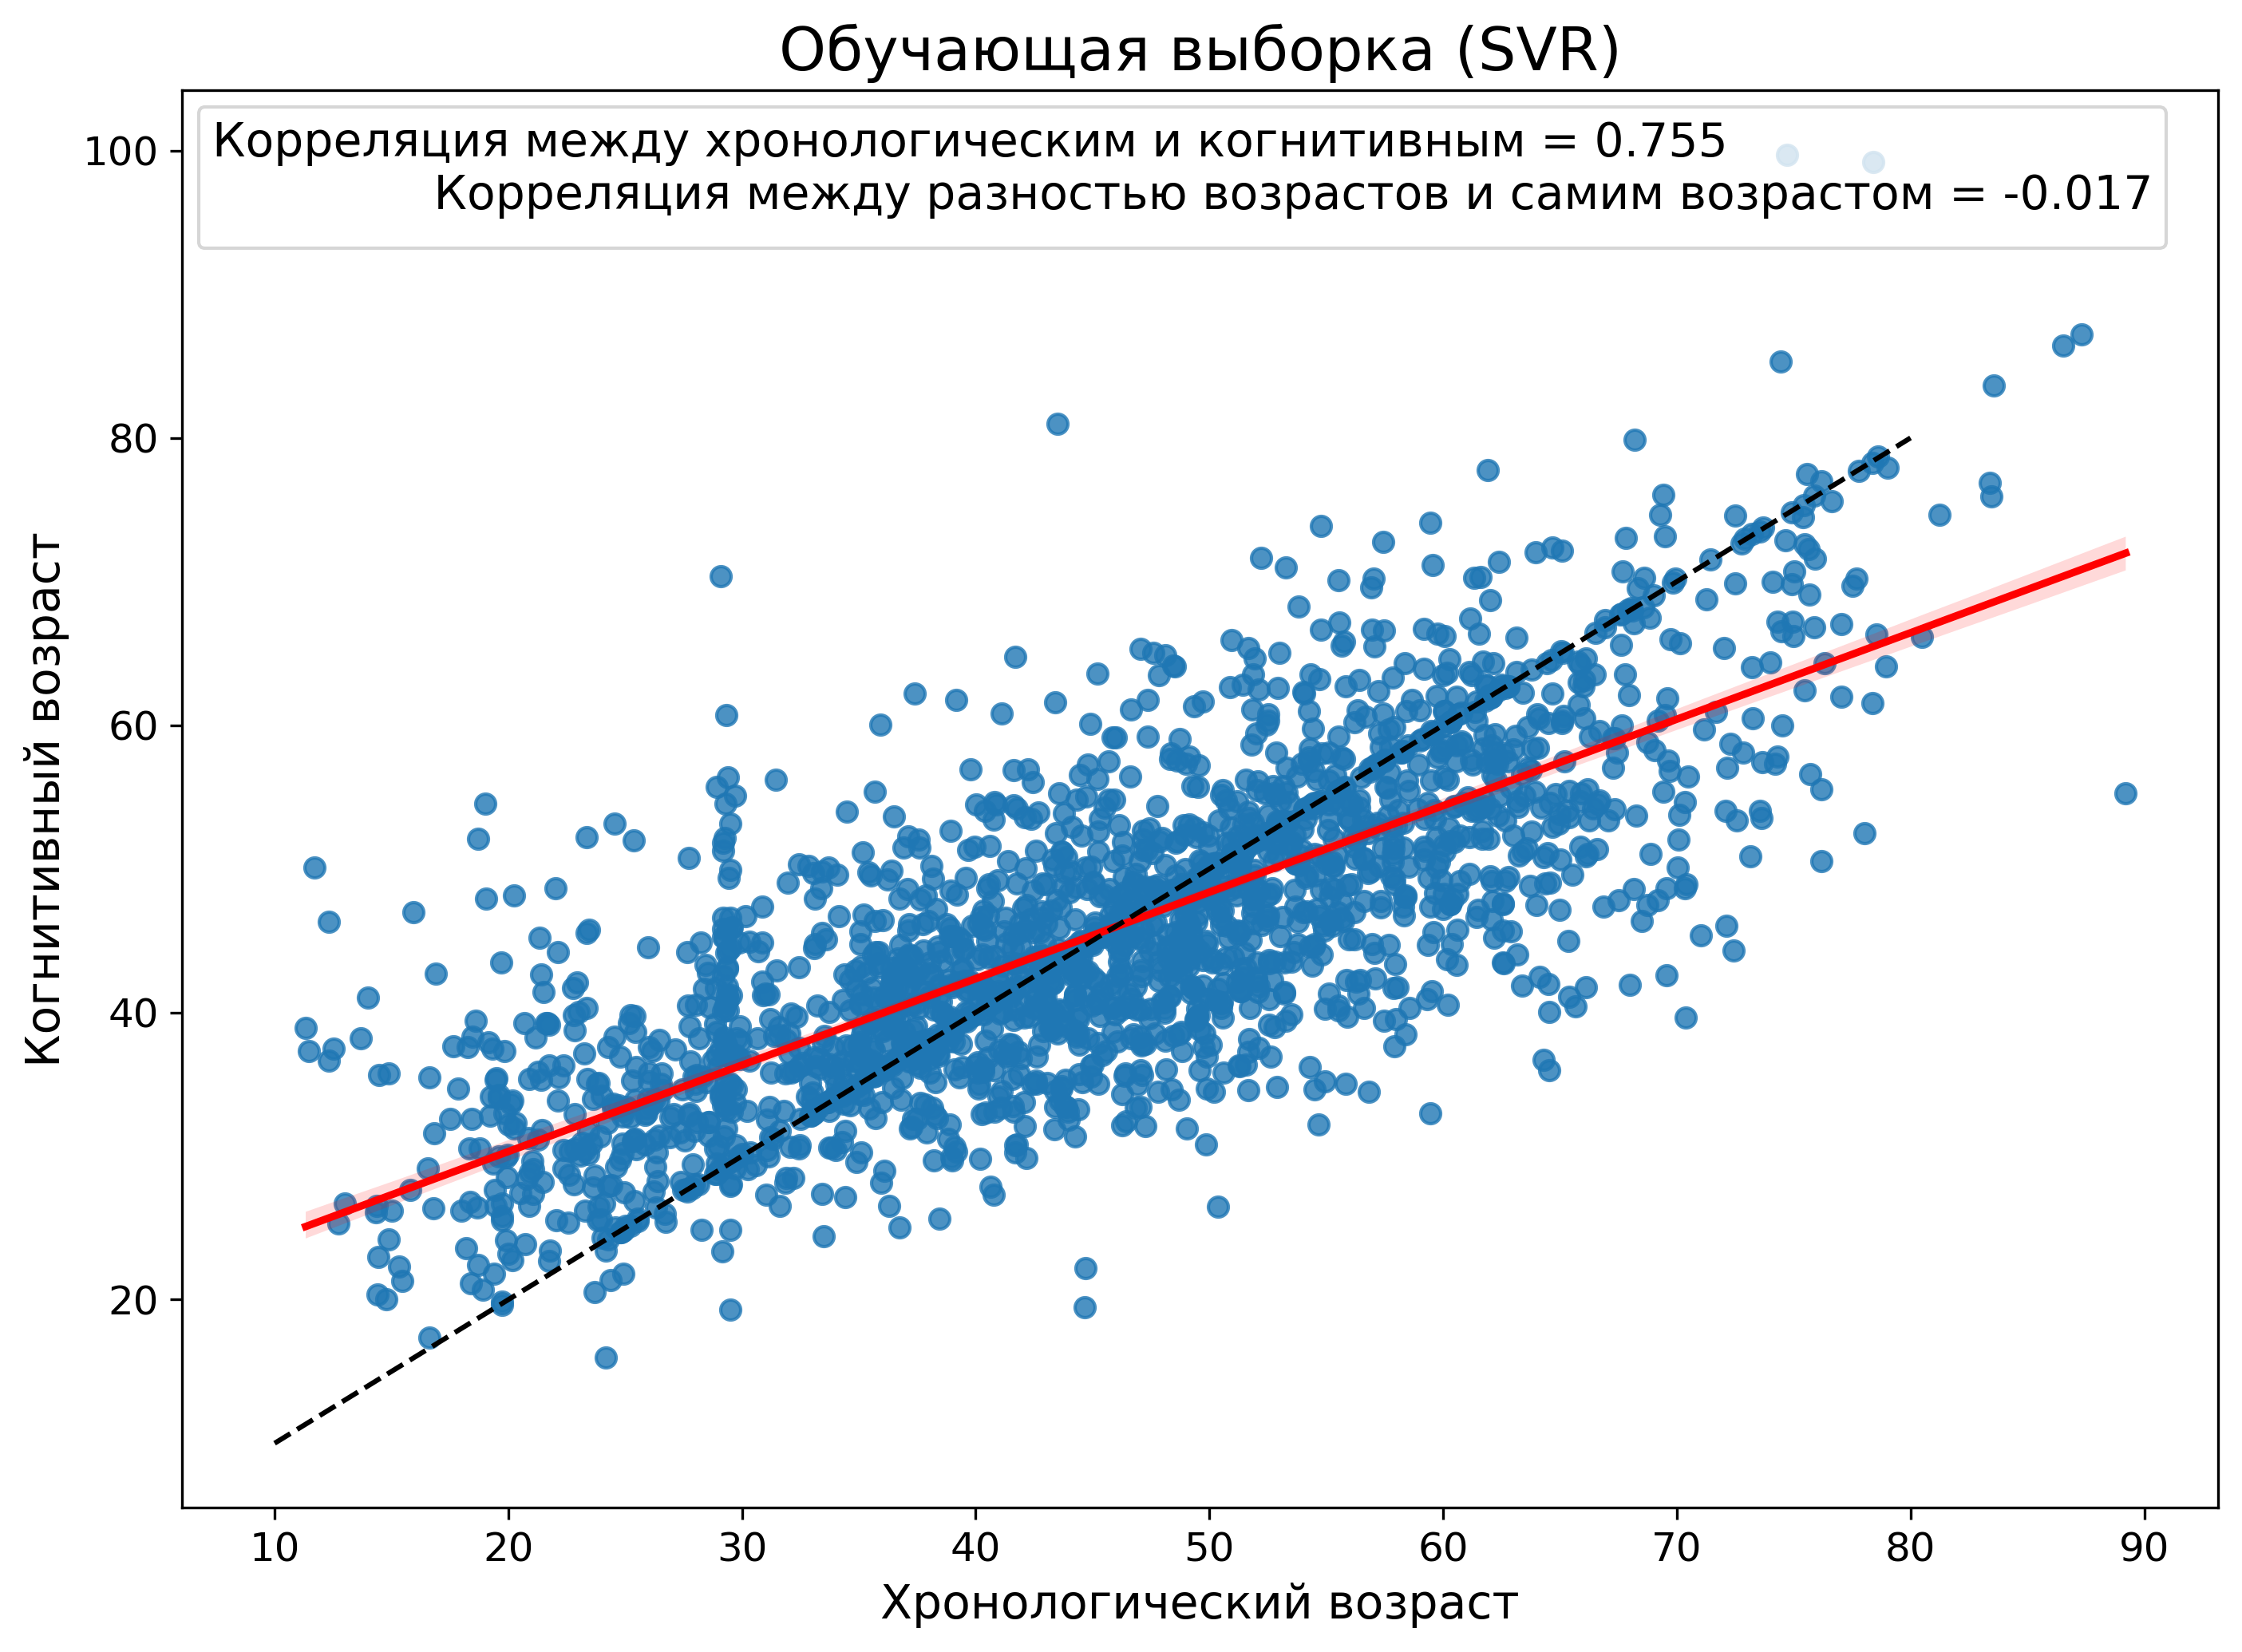

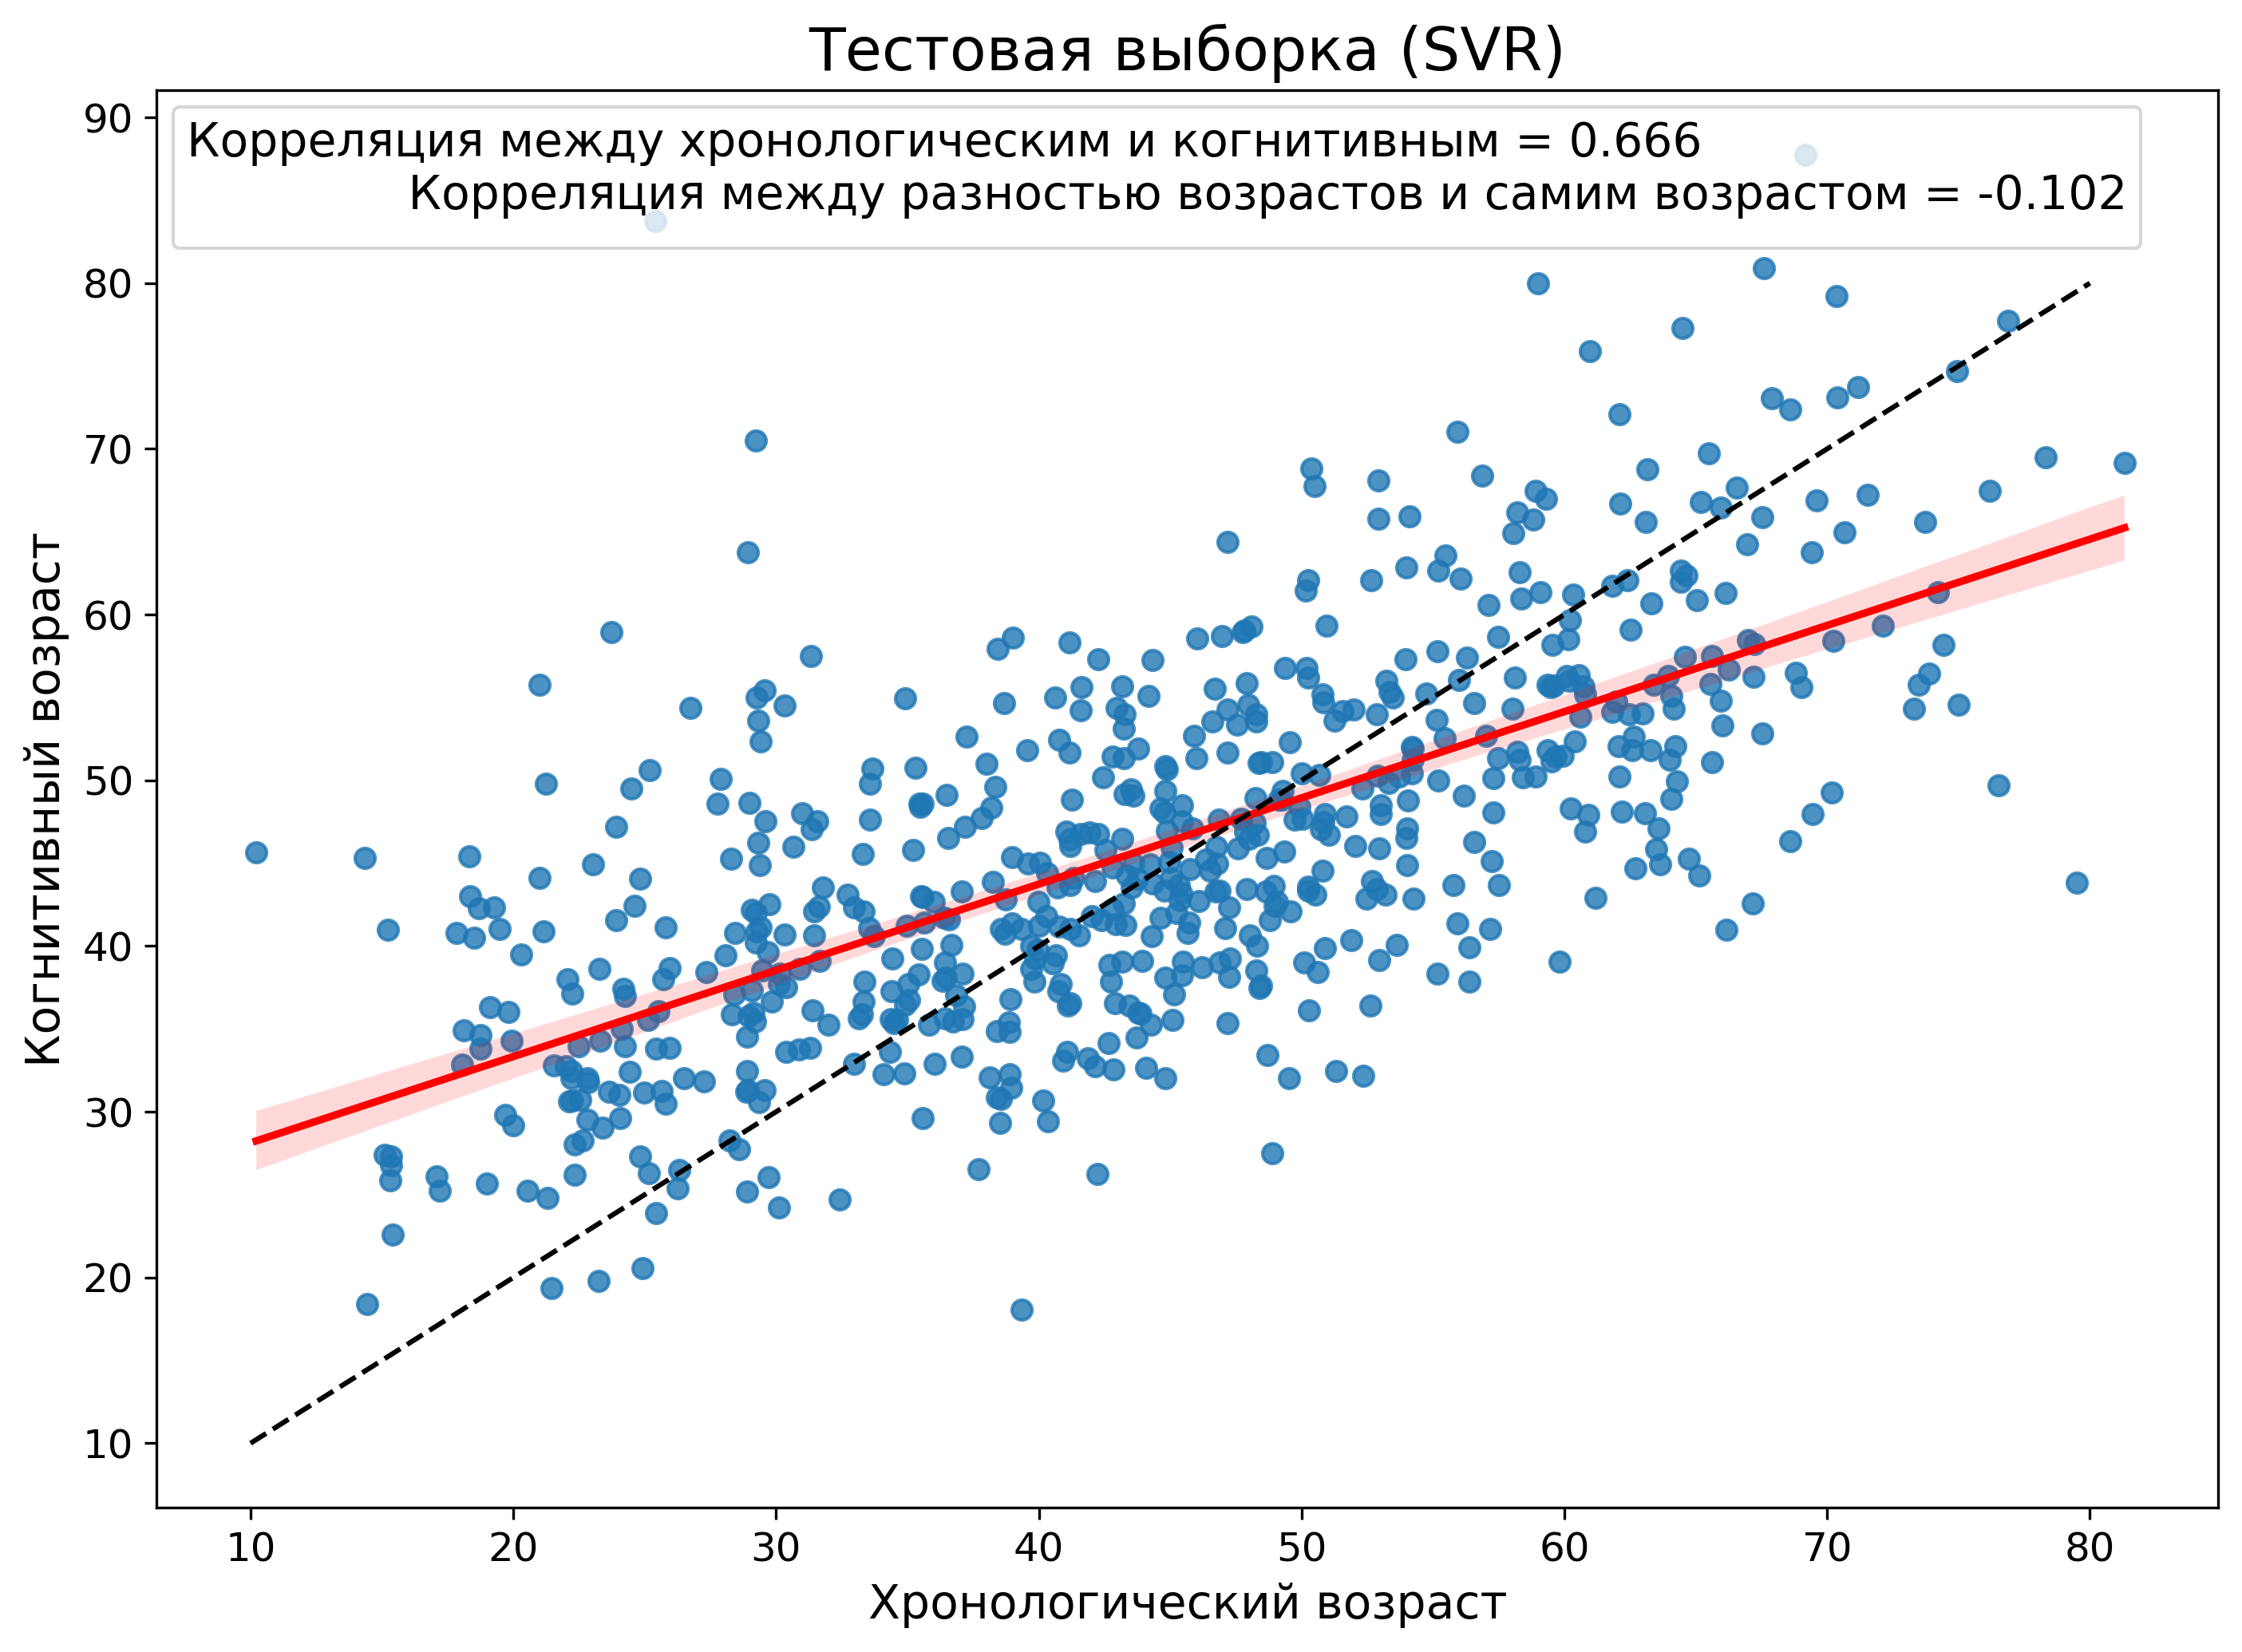

In [6]:
def scatterplot_with_ages(y1, y2, label): 
    ages_df = pd.DataFrame({
        'Хронологический возраст': y1,
        'Когнитивный возраст': y2
    })

    plt.figure(figsize=(10, 7), dpi=300)

    r1, p = pearsonr(y1, y2)
    r2, p = spearmanr(abs(y2 - y1), y1)
    sns.regplot(
        data=ages_df,
        x='Хронологический возраст',
        y='Когнитивный возраст',
        line_kws={'color': 'red'}
    )
    
    plt.legend(title=f'Корреляция между хронологическим и когнитивным = {round(r1, 3)}\n\
               Корреляция между разностью возрастов и самим возрастом = {round(r2, 3)}', loc='upper left', title_fontsize=14)
    # TODO другую корреляцию для |y2 - y1|, y1
    plt.title(label=label, fontsize=18)
    plt.plot([10, 80], [10, 80], 'k--') 
    plt.xlabel('Хронологический возраст', fontsize = 14)
    plt.ylabel('Когнитивный возраст', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


scatterplot_with_ages(y_train, y_train_pred, label='Обучающая выборка (SVR)')
scatterplot_with_ages(y_test, y_test_pred, label='Тестовая выборка (SVR)')